In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

plt.set_cmap("gray")


<Figure size 432x288 with 0 Axes>

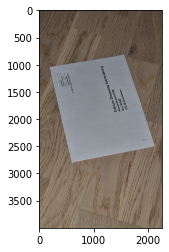

In [3]:
img = cv.imread("img/20220316_174022.jpg")
plt.imshow(img[:, :, ::-1])


In [4]:
def approxContours(cntr, epsilon=0.1):
    peri = cv.arcLength(cntr, True)
    return cv.approxPolyDP(cntr, epsilon * peri, True)


def distance(p1, p2) -> int:
    s1, s2 = np.subtract(p1, p2)
    return round(np.sqrt(s1 ** 2 + s2 ** 2))


def getCenter(cntr):
    m = cv.moments(cntr)
    return int(m["m10"] / m["m00"]), int(m["m01"] / m["m00"])


def getCornerPoints(cnt):
    leftmost = tuple(cnt[cnt[:, :, 0].argmin()][0])
    rightmost = tuple(cnt[cnt[:, :, 0].argmax()][0])
    topmost = tuple(cnt[cnt[:, :, 1].argmin()][0])
    bottommost = tuple(cnt[cnt[:, :, 1].argmax()][0])
    return {"l": leftmost, "r": rightmost, "t": topmost, "b": bottommost}


def alignSelection(img, cntr):
    points = getCornerPoints(cntr)
    topleft = points["l"]
    width = distance(topleft, points["t"])
    height = distance(topleft, points["b"])

    to_points = np.float32([(0, 0), (width, 0), (0, height), (width, height)])
    from_points = np.float32([points["l"], points["t"], points["b"], points["r"]])

    M = cv.getPerspectiveTransform(from_points, to_points)
    return cv.warpPerspective(img, M, (width, height))


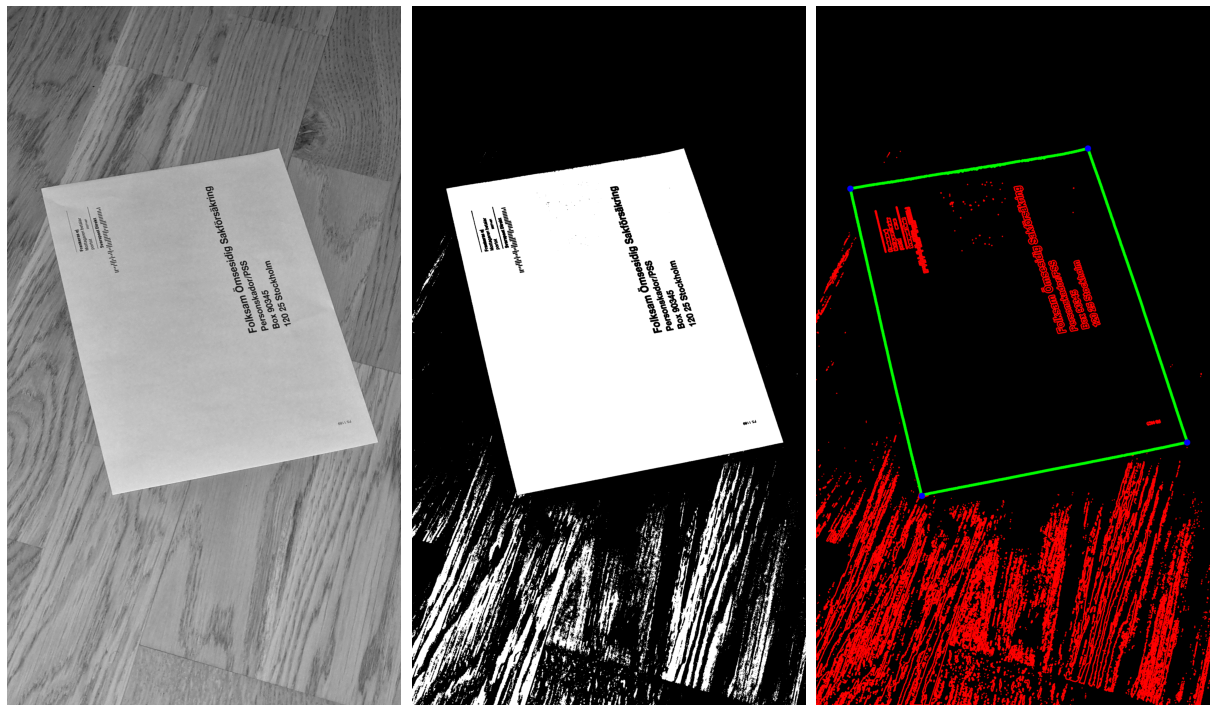

In [5]:
## selection preprocessing
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
pipe = cv.GaussianBlur(gray.copy(), (3, 3), 5)
h, pipe = cv.threshold(pipe, 127, 255, cv.THRESH_BINARY)

black = np.zeros(img.shape)
contours, h = cv.findContours(pipe, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(black, contours, -1, (1, 0, 0), 5)

biggest = max(contours, key=cv.contourArea)
cv.drawContours(black, biggest, -1, (0, 1, 0), 15)

approx_biggest = approxContours(biggest)
cv.drawContours(black, approx_biggest, -1, (0, 0, 1), 35)

fig, ax = plt.subplots(1, 3)
fig.set_tight_layout(True)
fig.set_size_inches(17, 10)
[a.axis("off") for a in ax]

ax[0].imshow(gray)
ax[1].imshow(pipe)
ax[2].imshow(black)


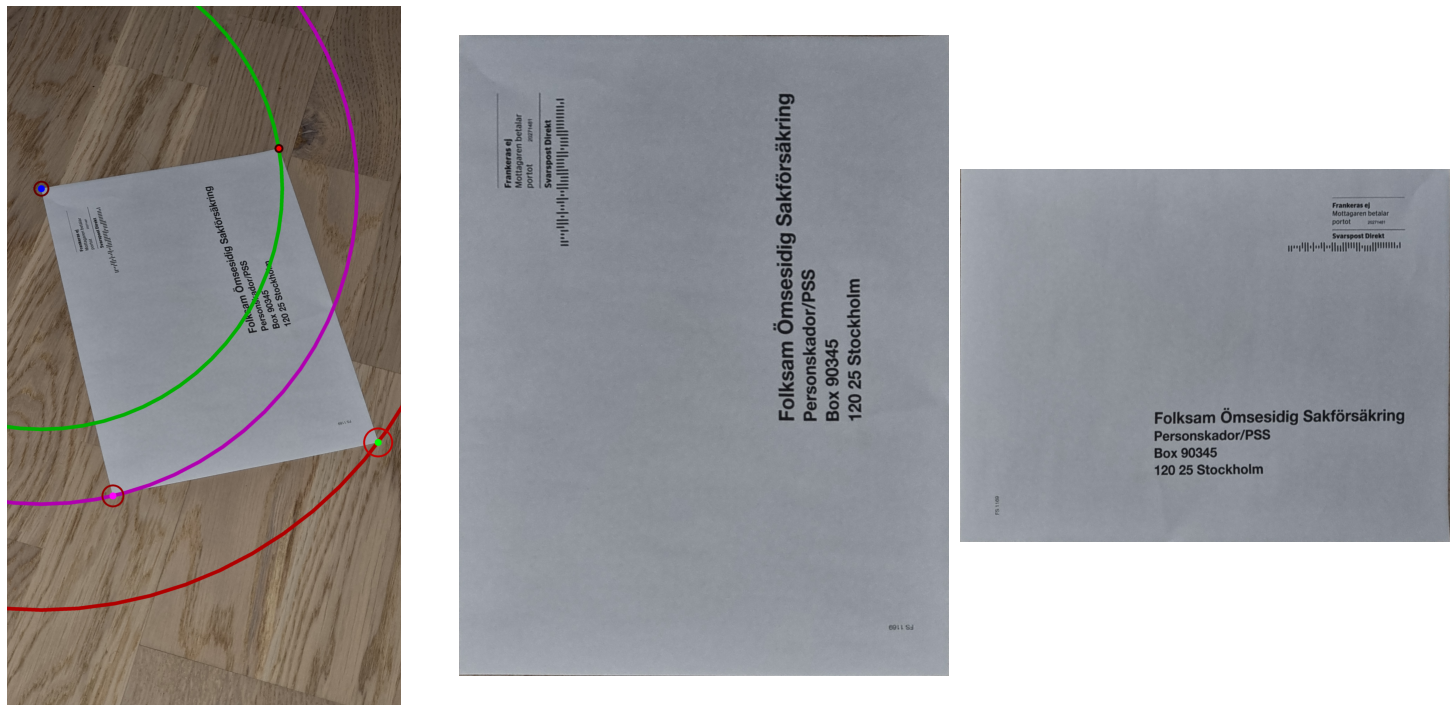

In [20]:
img_copy = img.copy()
points = getCornerPoints(approx_biggest)

topleft = points["l"]
width = distance(topleft, points["t"])
height = distance(topleft, points["b"])

cv.circle(img_copy, topleft, width, (0, 176, 0), 20)
cv.circle(img_copy, topleft, height, (176, 0, 176), 20)
cv.circle(img_copy, topleft, distance(topleft, points["r"]), (0, 0, 176), 20)

cv.circle(img_copy, points["l"], 20, (255, 0, 0), -1)  # BLUE
cv.circle(img_copy, points["r"], 20, (0, 255, 0), -1)  # GREEN
cv.circle(img_copy, points["t"], 20, (0, 0, 255), -1)  # RED
cv.circle(img_copy, points["b"], 20, (255, 0, 255), -1)  # Magenta

colors = [
    (0,0,50),
    (0,0,100),
    (0,0,150),
    (0,0,200),
]
for ix, ab in enumerate(approx_biggest):
    cv.circle(img_copy, center=ab[0], radius= 20 + ix * 20, color=colors[ix], thickness=10)


to_points = np.float32([(0, 0), (width, 0), (0, height), (width, height)])
from_points = np.float32([points["l"], points["t"], points["b"], points["r"]])


M = cv.getPerspectiveTransform(from_points, to_points)
dst = cv.warpPerspective(img, M, (width, height))


fig, ax = plt.subplots(1, 3)
fig.set_tight_layout(True)
fig.set_size_inches(21, 10)
[a.axis("off") for a in ax]
ax[0].imshow(img_copy[:, :, ::-1])
ax[1].imshow(dst[:, :, ::-1])
ax[2].imshow(cv.rotate(dst, cv.ROTATE_90_CLOCKWISE)[:, :, ::-1])


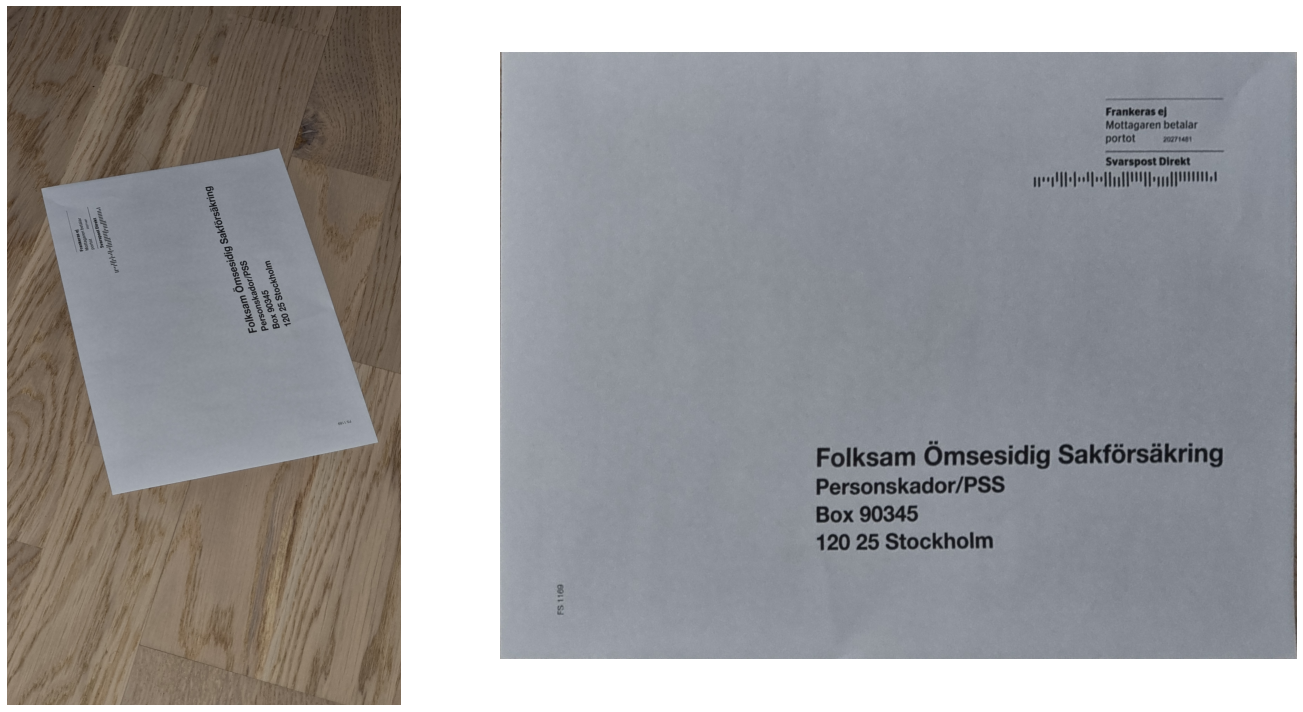

In [7]:

img_out = alignSelection(img.copy(), approx_biggest)
img_out = cv.rotate(img_out, cv.ROTATE_90_CLOCKWISE)

fig, ax = plt.subplots(1, 2)
fig.set_tight_layout(True)
fig.set_size_inches(21, 10)
[a.axis("off") for a in ax]
ax[0].imshow(img[:, :, ::-1])
ax[1].imshow(img_out[:, :, ::-1])

In [8]:
np.ones((2,2), dtype=np.int0)

array([[1, 1],
       [1, 1]])

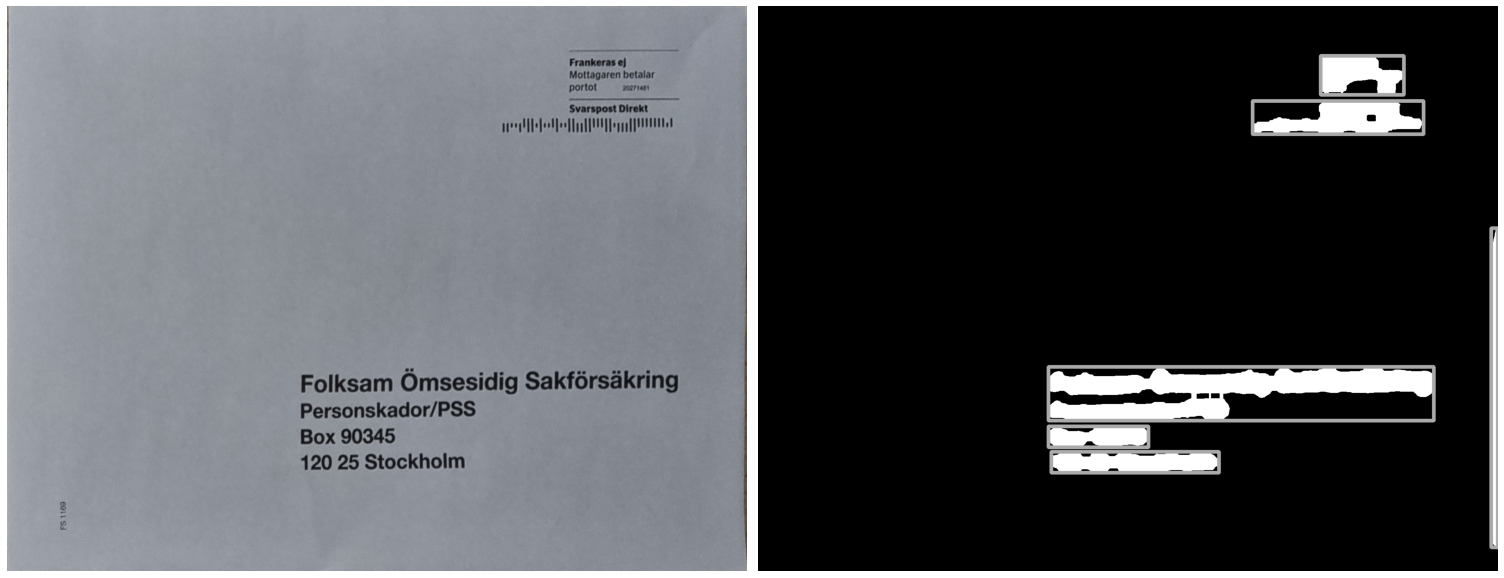

In [9]:
## Text preprocessing
pipe = cv.cvtColor(img_out, cv.COLOR_BGR2GRAY)
pipe = cv.GaussianBlur(pipe, (31, 31), 21)
_, pipe = cv.threshold(pipe, 127, 255, cv.THRESH_BINARY_INV)
pipe = cv.dilate(pipe, np.ones((11, 11)))
pipe = cv.erode(pipe, np.ones((12, 12)))

contours, _ = cv.findContours(pipe, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

for cntr in contours:
    react = cv.boundingRect(cntr)
    cv.rectangle(pipe, react, color=(170), thickness=7)


fig, ax = plt.subplots(1, 2)
fig.set_tight_layout(True)
fig.set_size_inches(21, 10)
[a.axis("off") for a in ax]
ax[0].imshow(img_out[:, :, ::-1])
ax[1].imshow(pipe)


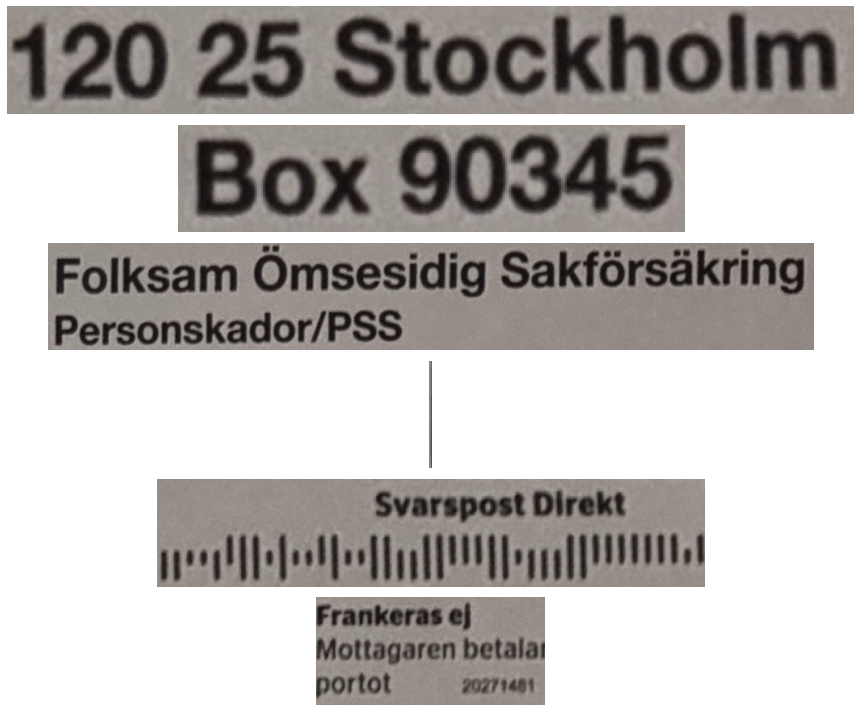

In [10]:
text_areas = [cv.boundingRect(c) for c in contours]

images = []

for x,y,w,h in text_areas:
    images.append(img_out[y:y+h, x:x+w])


fig, ax = plt.subplots(len(images))
fig.set_tight_layout(True)
fig.set_size_inches(21, 10)
[a.axis("off") for a in ax]
for ix, i in enumerate(images):
    ax[ix].imshow(i)

# ax[0].imshow(img_out[:, :, ::-1])
